##### Copyright 2018 The TensorFlow Authors.

# 6.1 Train your first neural network: basic classification

This guide trains a neural network model to classify images of clothing, like sneakers and shirts. It's okay if you don't understand all the details, this is a fast-paced overview of a complete TensorFlow program with the details explained as we go.

This guide uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

In [2]:
# Helper libraries
import numpy as np

In [3]:
import matplotlib.pyplot as plt

print(tf.__version__)

1.14.0


## 6.2 Import the Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:
<table>
  <tr><td>
    <img src="pic/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc) in an identical format to the articles of clothing we'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code. 

We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow, just import and load the data:

In [4]:
import gzip
import os
from tensorflow.python.util.tf_export import tf_export

base = 'data/fashion_MNIST_data/'

def load_data(base):
    files = [
        'train-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz',
        't10k-labels-idx1-ubyte.gz', 't10k-images-idx3-ubyte.gz'
    ]
    paths = []
    for fname in files:
        paths.append(base + fname)

    with gzip.open(paths[0], 'rb') as lbpath:
        y_train = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(paths[1], 'rb') as imgpath:
        x_train = np.frombuffer(
            imgpath.read(), np.uint8, offset=16).reshape(len(y_train), 28, 28)

    with gzip.open(paths[2], 'rb') as lbpath:
        y_test = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(paths[3], 'rb') as imgpath:
        x_test = np.frombuffer(
            imgpath.read(), np.uint8, offset=16).reshape(len(y_test), 28, 28)

    return (x_train, y_train), (x_test, y_test)

(train_images, train_labels), (test_images, test_labels) = load_data(base)

Loading the dataset returns four NumPy arrays:

* The `train_images` and `train_labels` arrays are the *training set*—the data the model uses to learn.
* The model is tested against the *test set*, the `test_images`, and `test_labels` arrays.

The images are 28x28 NumPy arrays, with pixel values ranging between 0 and 255. The *labels* are an array of integers, ranging from 0 to 9. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th> 
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td> 
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td> 
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td> 
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td> 
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td> 
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td> 
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td> 
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td> 
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td> 
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td> 
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## 6.3 Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, with each image represented as 28 x 28 pixels:

In [6]:
train_images.shape

(60000, 28, 28)

Likewise, there are 60,000 labels in the training set:

In [7]:
len(train_labels)

60000

Each label is an integer between 0 and 9:

In [8]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

There are 10,000 images in the test set. Again, each image is represented as 28 x 28 pixels:

In [9]:
test_images.shape

(10000, 28, 28)

And the test set contains 10,000 images labels:

In [10]:
len(test_labels)

10000

## 6.4 Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

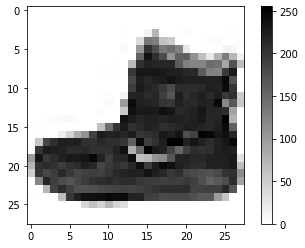

In [11]:
plt.figure()
plt.imshow(train_images[0],cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)

We scale these values to a range of 0 to 1 before feeding to the neural network model. For this, cast the datatype of the image components from an integer to a float, and divide by 255. Here's the function to preprocess the images:

It's important that the *training set* and the *testing set* are preprocessed in the same way:

In [12]:
train_images = train_images / 255.0

test_images = test_images / 255.0

Display the first 25 images from the *training set* and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

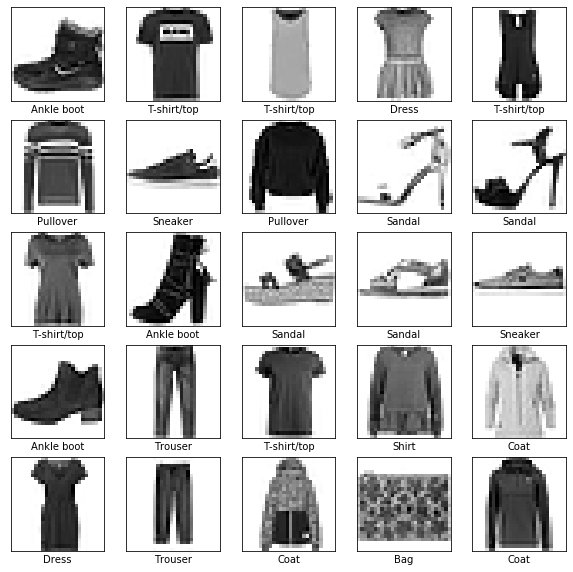

In [13]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

## 6.5 Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Setup the layers

The basic building block of a neural network is the *layer*. Layers extract representations from the data fed into them. And, hopefully, these representations are more meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers, like `tf.keras.layers.Dense`, have parameters that are learned during training.

In [14]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

W0816 10:25:44.350939 16184 deprecation.py:506] From D:\APPs\Anaconda\envs\Jeary_lab\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


The first layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a 2d-array (of 28 by 28 pixels), to a 1d-array of 28 * 28 = 784 pixels. Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are densely-connected, or fully-connected, neural layers. The first `Dense` layer has 128 nodes (or neurons). The second (and last) layer is a 10-node *softmax* layer—this returns an array of 10 probability scores that sum to 1. Each node contains a score that indicates the probability that the current image belongs to one of the 10 classes.

### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's *compile* step:

* *Loss function* —This measures how accurate the model is during training. We want to minimize this function to "steer" the model in the right direction.
* *Optimizer* —This is how the model is updated based on the data it sees and its loss function.
* *Metrics* —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [15]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## 6.6 Train the model

Training the neural network model requires the following steps:

1. Feed the training data to the model—in this example, the `train_images` and `train_labels` arrays.
2. The model learns to associate images and labels.
3. We ask the model to make predictions about a test set—in this example, the `test_images` array. We verify that the predictions match the labels from the `test_labels` array. 

To start training,  call the `model.fit` method—the model is "fit" to the training data:

In [16]:
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 4s 60us/sample - loss: 0.5015 - acc: 0.8224
Epoch 2/5
60000/60000 [==============================] - 4s 58us/sample - loss: 0.3765 - acc: 0.8649
Epoch 3/5
60000/60000 [==============================] - 4s 61us/sample - loss: 0.3389 - acc: 0.8764
Epoch 4/5
60000/60000 [==============================] - 4s 60us/sample - loss: 0.3139 - acc: 0.8838
Epoch 5/5
60000/60000 [==============================] - 4s 63us/sample - loss: 0.2951 - acc: 0.8914


As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.88 (or 88%) on the training data.

## 6.7 Evaluate accuracy

Next, compare how the model performs on the test dataset:

In [17]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

10000/10000 [==============================] - 0s 33us/sample - loss: 0.3674 - acc: 0.8673
Test accuracy: 0.8673


It turns out, the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy is an example of *overfitting*. Overfitting is when a machine learning model performs worse on new data than on their training data. 

## 6.8 Make predictions

With the model trained, we can use it to make predictions about some images.

In [18]:
predictions = model.predict(test_images)

Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [19]:
predictions[0]

array([4.7425391e-07, 3.2016182e-08, 2.6471669e-08, 1.5291491e-08,
       5.0633923e-07, 4.7788996e-02, 5.9296644e-06, 6.5712348e-02,
       4.1198809e-04, 8.8607973e-01], dtype=float32)

A prediction is an array of 10 numbers. These describe the "confidence" of the model that the image corresponds to each of the 10 different articles of clothing. We can see which label has the highest confidence value:

In [20]:
np.argmax(predictions[0])

9

So the model is most confident that this image is an ankle boot, or `class_names[9]`. And we can check the test label to see this is correct:

In [21]:
test_labels[0]

9

We can graph this to look at the full set of 10 channels

In [22]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Let's look at the 0th image, predictions, and prediction array. 

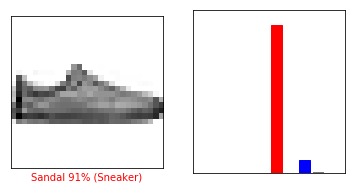

In [27]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)

Let's plot several images with their predictions. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percent (out of 100) for the predicted label. Note that it can be wrong even when very confident. 

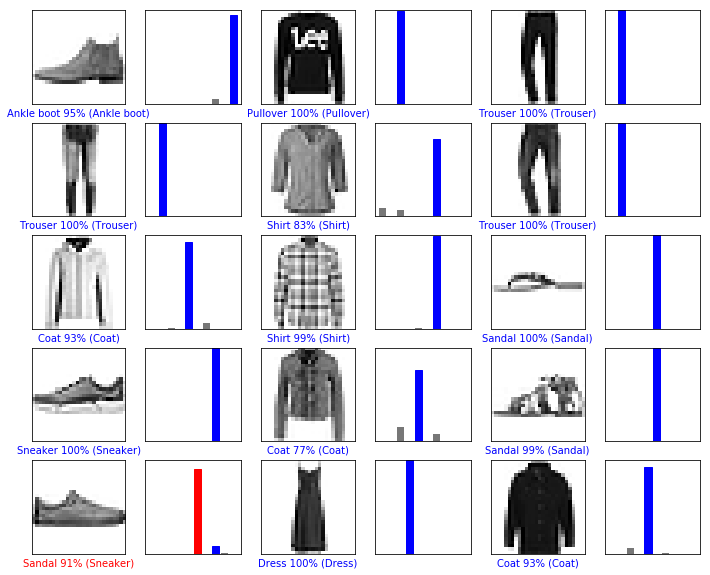

In [28]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)


Finally, use the trained model to make a prediction about a single image. 
## 6.9 Inference

In [29]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28)


`tf.keras` models are optimized to make predictions on a *batch*, or collection, of examples at once. So even though we're using a single image, we need to add it to a list:

In [30]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))
print(img.shape)

(1, 28, 28)


Now predict the image:

In [31]:
predictions_single = model.predict(img)

print(predictions_single)

[[2.3479717e-07 1.6312808e-09 4.9103568e-07 2.1180178e-07 3.6350126e-08
  5.4030679e-04 7.5736654e-07 5.1942393e-02 1.4514594e-06 9.4751412e-01]]


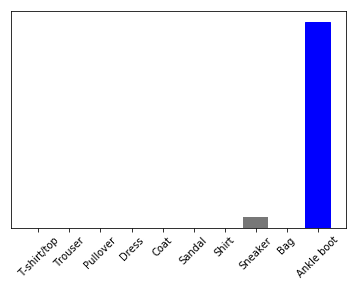

In [32]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

`model.predict` returns a list of lists, one for each image in the batch of data. Grab the predictions for our (only) image in the batch:

In [33]:
np.argmax(predictions_single[0])

9

![embedding](pic/embedding.gif)